In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import math
from math import sqrt
import matplotlib
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import lstm, time

C:\Users\john\AppData\Local\conda\conda\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
f = open('encrypto.csv', 'r').read()
data = f.split('\n')

diff_log = []
for i in range(1, 2640):
    diff_log.append(np.log(float(data[i]))-np.log(float(data[i-1])))

result = []
for i in range(0, 2640 - 121):#121 is the shifting window size, 120 to train, 1 to predict
    result.append(diff_log[i: i + 121])

#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = scaler.fit(result)
#transformed = scaler.transform(result)

transformed = np.reshape(result, (2640-121,121))

x = []
for i in range(0, 2640 - 121):#121 is the shifting window size, 120 to train, 1 to predict
    x.append(transformed[i][0:-1])
y = []
for i in range(0, 2640 - 121):#121 is the shifting window size, 120 to train, 1 to predict
    y.append(transformed[i][-1])
x_train = np.reshape(x, (2640-121,121-1, 1))#121 is the shifting window size, 120 to train, 1 to predict
y_train = np.reshape(y, (2640-121))#121 is the shifting window size, 120 to train, 1 to predict
x_vali = x_train[2640-60-121:2641-60-121]#121 is the shifting window size, 120 to train, 1 to predict
y_vali = y_train[2640-60-121:2640-121]#121 is the shifting window size, 120 to train, 1 to predict

In [9]:
y_vali

array([ 0.01390028,  0.04606111,  0.04387965,  0.03375608,  0.0447714 ,
       -0.02907476,  0.03583954, -0.01745118, -0.02591579,  0.00781041,
       -0.01597621, -0.00964875,  0.01413786,  0.00900132,  0.02803258,
        0.00731868, -0.00332023,  0.00112389,  0.00715523,  0.03212103,
       -0.00262533,  0.01998901,  0.02678394, -0.04477439, -0.00185345,
       -0.04881186,  0.01640004,  0.03166028,  0.00171962, -0.0501333 ,
       -0.00417265, -0.01662145, -0.00038926, -0.00681273, -0.04783569,
       -0.12808923,  0.09339115, -0.00155099, -0.00117503,  0.07142353,
       -0.02990279, -0.00702435, -0.04600565, -0.00181791,  0.03300777,
       -0.02167522,  0.04897261, -0.00572494,  0.05410716, -0.00388118,
       -0.00355308,  0.03106361,  0.00665621,  0.00150522, -0.01348178,
       -0.01542747,  0.01585835,  0.00764831,  0.01061711,  0.02406331])

In [226]:
model = Sequential()
model.add(LSTM(input_dim=1,output_dim=240,return_sequences=True))#use double the window-1 as 1st layer output
model.add(Dropout(0.2))

model.add(LSTM(input_dim=240,output_dim=240,return_sequences=True))#use window-1 as 2nd layer output
model.add(Dropout(0.2))

model.add(LSTM(input_dim=240,output_dim=120,return_sequences=True))#use half the window-1 as 3rd layer output
model.add(Dropout(0.2))

model.add(LSTM(120,return_sequences=False))#use half the window-1 as 4st layer input
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.03125


In [227]:
history = model.fit(x_train,y_train,batch_size=128,nb_epoch=5,validation_split=240/(2640-121))

Train on 2279 samples, validate on 240 samples
Epoch 1/5
2279/2279 [==============================] - 152s 67ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 2/5
2279/2279 [==============================] - 121s 53ms/step - loss: 0.0016 - val_loss: 9.9609e-04
Epoch 3/5
2279/2279 [==============================] - 125s 55ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/5
2279/2279 [==============================] - 124s 54ms/step - loss: 0.0016 - val_loss: 9.9013e-04
Epoch 5/5
2279/2279 [==============================] - 125s 55ms/step - loss: 0.0016 - val_loss: 9.9168e-04


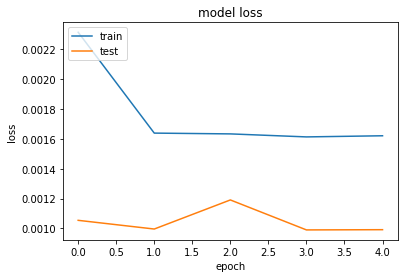

In [228]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [229]:
curr_frame = x_vali
predicted = []
for i in range(0,60):
    predicted.append(model.predict(curr_frame))
    curr_frame = curr_frame[0][1:121-1]#121 is the shifting window size, 120 to train, 1 to predict
    curr_frame = np.insert(curr_frame, [121-2], predicted[-1], axis=0)#121 is the shifting window size, 120 to train, 1 to predict
    curr_frame = np.reshape(curr_frame, (1,121-1, 1))#121 is the shifting window size, 120 to train, 1 to predict
predicted_reshape = np.reshape(np.array(predicted),(60))

In [230]:
previous_price=[295.1347521]
predicted_price = []
for i in range(0,60):
    predicted_price.append(math.exp(np.log(previous_price)+predicted_reshape[i]))
    previous_price = predicted_price[-1]

In [231]:
previous_price=[295.1347521]
actual_price = []
for i in range(0,60):
    actual_price.append(math.exp(np.log(previous_price)+y_vali[i]))
    previous_price = actual_price[-1]

In [232]:
rmse = sqrt(sum((np.asarray(predicted_price)-np.asarray(actual_price))**2)/60)
rmse

43.614400548108314

Prediction vs True data


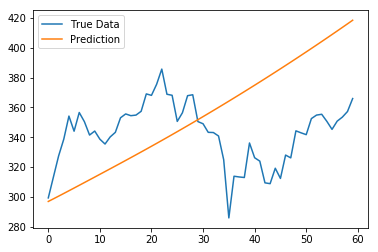

In [233]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(actual_price, label='True Data')
print ('Prediction vs True data')
plt.plot(predicted_price, label='Prediction')
plt.legend()
plt.show()

In [110]:
inverse_scale=y_vali*(scaler.data_max_[120]-scaler.data_min_[120])+scaler.data_min_[120]

In [106]:
scaler.data_max_[120]

0.2972056531195023

In [107]:
scaler.data_min_[120]

-0.3440695919002055

In [141]:
predicted_price

[292.26799403720514,
 289.42667966888627,
 286.6115599066794,
 283.8231654453066,
 281.06174644912994,
 278.32731457915287,
 275.6197191549669,
 272.93872708377063,
 270.28408022725563,
 267.655533085194,
 265.052862891886,
 262.47587201919384,
 259.92437762197545,
 257.3982004158372,
 254.89715409012402,
 252.4210386255234,
 249.96963331352345,
 247.54269688834847,
 245.13997156223977,
 242.76118165572709,
 240.40604151215493,
 238.07425876591287,
 235.76553897407902,
 233.47958803393453,
 231.2161187727092,
 228.9748490534515,
 226.75550610906578,
 224.55782622872573,
 222.38155652372296,
 220.22645206877147,
 218.09227868133797,
 215.97881009996854,
 213.88582730612782,
 211.8131182712632,
 209.76047712459294,
 207.72770394198446,
 205.714601858272,
 203.72097908431027,
 201.74664704647597,
 199.7914195593808,
 197.85511351805135,
 195.93754790587826,
 194.03854412258895,
 192.15792414432187,
 190.29551268790303,
 188.45113573987587,
 186.62462055927702,
 184.815796196402,
 183.0244

In [111]:
inverse_scale

array([-0.32820462, -0.26940509, -0.20508343, -0.20944635, -0.22969349,
       -0.20766285, -0.35535517, -0.22552658, -0.33210801, -0.34903724,
       -0.28158484, -0.32915808, -0.31650316, -0.26892994, -0.27920301,
       -0.24114048, -0.2825683 , -0.30384612, -0.29495787, -0.28289519,
       -0.23296359, -0.3024563 , -0.25722763, -0.24363778, -0.38675444,
       -0.30091256, -0.39482937, -0.26440557, -0.23388509, -0.2937664 ,
       -0.39747226, -0.30555096, -0.33044856, -0.29798417, -0.31083111,
       -0.39287704, -0.55338411, -0.11042335, -0.30030763, -0.29955571,
       -0.1543586 , -0.35701123, -0.31125435, -0.38921696, -0.30084147,
       -0.23119012, -0.3405561 , -0.19926043, -0.30865553, -0.18899134,
       -0.30496802, -0.30431182, -0.23507844, -0.28389324, -0.29419522,
       -0.32416922, -0.3280606 , -0.26548895, -0.28190904, -0.27597142])

In [102]:
predicted_reshape

array([0.05084993, 0.05096739, 0.05100506, 0.05095674, 0.05083358,
       0.05065665, 0.05045038, 0.05023785, 0.05003801, 0.04986458,
       0.04972593, 0.04962575, 0.04956401, 0.04953792, 0.04954296,
       0.04957371, 0.04962439, 0.04968946, 0.04976385, 0.04984314,
       0.04992371, 0.05000266, 0.05007787, 0.0501478 , 0.05021153,
       0.05026855, 0.05031876, 0.05036228, 0.05039949, 0.05043084,
       0.05045692, 0.0504783 , 0.0504956 , 0.05050939, 0.05052019,
       0.05052852, 0.05053481, 0.05053943, 0.05054272, 0.05054498,
       0.05054642, 0.05054725, 0.05054763, 0.05054767, 0.0505475 ,
       0.05054716, 0.05054675, 0.05054628, 0.0505458 , 0.05054533,
       0.05054488, 0.05054447, 0.05054409, 0.05054376, 0.05054348,
       0.05054323, 0.05054301, 0.05054282, 0.05054267, 0.05054256],
      dtype=float32)

In [109]:
y_vali

array([ 0.02473972,  0.11643129,  0.21673402,  0.20993051,  0.17835727,
        0.21271169, -0.01759865,  0.18485513,  0.01865281, -0.00774652,
        0.09743828,  0.0232529 ,  0.0429869 ,  0.11717223,  0.10115249,
        0.16050691,  0.09590467,  0.06272419,  0.07658447,  0.09539493,
        0.17325791,  0.06489146,  0.13542073,  0.15661264, -0.06656244,
        0.06729876, -0.07915443,  0.12422751,  0.17182092,  0.07844243,
       -0.08327573,  0.06006568,  0.02124054,  0.07186527,  0.05183186,
       -0.07610998, -0.32640355,  0.36434627,  0.0682421 ,  0.06941463,
        0.29583395, -0.0201811 ,  0.05117185, -0.07040248,  0.06740962,
        0.17602344,  0.00547891,  0.22581437,  0.05522443,  0.24182791,
        0.06097471,  0.06199799,  0.16996002,  0.09383857,  0.07777373,
        0.0310325 ,  0.02496431,  0.12253808,  0.09693272,  0.10619179])

In [ ]:
transformed.shape

In [ ]:
inverted

In [ ]:
predictions